In [3]:
import numpy as np
import math
import torch

from sam.models import MultiHeadAttentionLayer, create_transformer
from sam.dataset import get_dataloader

from configurations import load_data, make_params_dict, create_fig, set_font_sizes, apply_general_styles

apply_general_styles()


# Planted transformer?

In [5]:
V = 10
L = 5
d = V + L

E = torch.eye(d)
P = torch.eye(L)

input = torch.tensor([0, 1, 4, 2 , 1])

# Make X = (E[input],P)  with shape (L, V+L)
# # X = E[input]


# Runs

In [89]:
d_model = 32
d_eff = 16
vocab_size = 20
seq_len = 16
batch_size = 64
dataset_size = 10000
train_fraction = 0.8
fr_emb = True

sigma = 0.2
lr = 0.0001
n_heads = 1
n_layers = 2
dropout = 0.1
sparsity = 0.0

fix_names = ['d_model','d_eff','vocab_size','seq_len','batch_size','dataset_size','train_fraction','fr_emb']
var_names = ['sigma','lr','n_heads','n_layers','dropout','sparsity']

params = make_params_dict(fix_names, var_names)
summary = load_data('summary',experiment_name='copy_task', params=params)

for key in summary:
    print(f'{key} : {summary[key].shape}')
    

File summary_dropout0.1_lr0.0001_n_heads1_n_layers2_sigma0.2_sparsity0.pkl loaded with pickle.load from /u/c/cerazova/SAM/data/copy_task/batch_size64_d_eff16_d_model32_dataset_size10000_fr_embTrue_seq_len16_train_fraction0.8_vocab_size20
step : (50,)
train_loss : (50,)
val_loss : (50,)
train_accuracy : (0,)
val_accuracy : (50,)


(0.0, 0.119825)

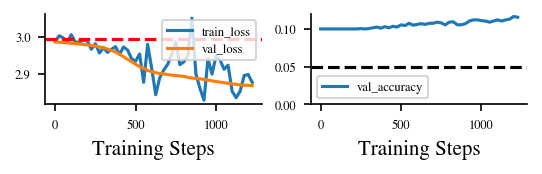

In [90]:
# Settings

set_font_sizes(conf='tight')

# Figure and plot
fig , axes = create_fig(ncols=2,h=0.3)

for ax , vars in zip(axes, [['train_loss','val_loss'], ['val_accuracy']]):
    for key in vars: 
        ax.plot('step', key, data=summary, label=key)
    ax.legend()
    ax.set_xlabel('Training Steps')
    
axes[0].axhline(y=math.log(vocab_size), color='r', linestyle='--')
axes[1].axhline(y=1/vocab_size, color='k', linestyle='--')
axes[1].set_ylim(bottom=0)

In [74]:
print(np.max(summary['val_accuracy']))
print(summary['step'][-1])

0.2305
61250


# Oth

In [13]:
config = {
    'd_model': 128,
    'd_eff': 32,
    'vocab_size': 100,
    'seq_len': 64,
    'n_heads': 3,
    'n_layers': 2,
    'dropout': 0.0,
    'sigma': 0.2,
    'batch_size': 16,
    'dataset_size': 1000,
    'train_fraction': 0.8,
    'lr': 1e-3,
}
model , device = create_transformer(config)
train_dataloader, val_dataloader = get_dataloader(config)


In [14]:
CE_loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=config['lr'],eps=1e-9)

print(f'{math.log(config["vocab_size"]):.4f} bits per token')

for batch in train_dataloader:
    input = batch['input'].to(device)
    target = batch['target'].to(device)
    mask = batch['mask'].to(device)

    logits = model(input, mask)
    loss = CE_loss(logits.view(-1, config['vocab_size']), target.view(-1))
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    print('Loss:', loss.item())





4.6052 bits per token
Loss: 4.588139057159424
Loss: 4.619813442230225
Loss: 4.606714725494385
Loss: 4.587735176086426
Loss: 4.588291645050049
Loss: 4.5869140625
Loss: 4.626347541809082
Loss: 4.627076625823975
Loss: 4.589531898498535
Loss: 4.587806224822998
Loss: 4.573376178741455
Loss: 4.556177139282227
Loss: 4.590441703796387
Loss: 4.623620986938477
Loss: 4.603174686431885
Loss: 4.614871501922607
Loss: 4.621535301208496
Loss: 4.6000237464904785
Loss: 4.5897746086120605
Loss: 4.555007457733154
Loss: 4.634619235992432
Loss: 4.516538619995117
Loss: 4.585512638092041
Loss: 4.455668926239014
Loss: 4.72534704208374
Loss: 4.5669403076171875
Loss: 4.765915393829346
Loss: 4.622761249542236
Loss: 4.678926467895508
Loss: 4.548009395599365
Loss: 4.610970497131348
Loss: 4.550774097442627
Loss: 4.58305025100708
Loss: 4.613428592681885
Loss: 4.632364273071289
Loss: 4.610985279083252
Loss: 4.59404993057251
Loss: 4.566056728363037
Loss: 4.613566875457764
Loss: 4.5711517333984375
Loss: 4.62340402603149

# Others

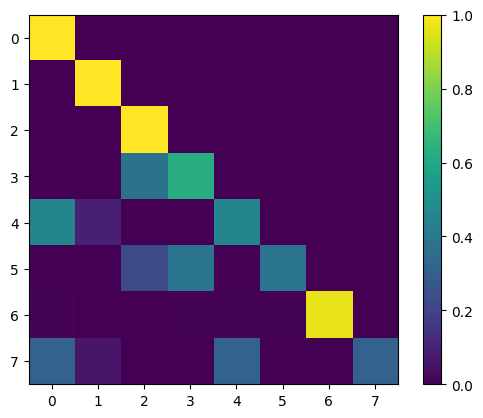

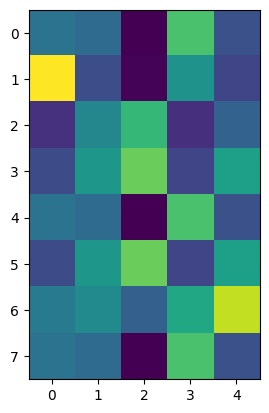

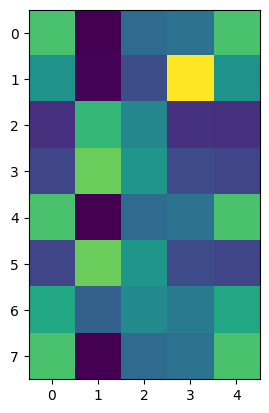

Predicted next token: 3


In [98]:
V = 5 # Vocabulary size
d = V # Embedding dimension for one-hot encoding
d_eff = 5 # Effective embedding dimension for Q, K, V
# embeddings = torch.eye(V, d) # One-hot encoding matrix
embeddings = torch.randn(V, d) # Random embedding matrix for demonstration
# Example of input sequence:
input = torch.tensor([1, 3, 0, 4, 1 , 4 , 2 , 1]) # Sequence of token indices
L = len(input) # Sequence length
# Positional encoding matrix (length L, dimension d) where all entries for position l are equal to l so that later positions have higher values

P = 0.*(L-torch.arange(L)).unsqueeze(1).repeat(1, d)/L
E = embeddings[input] # Embedded input sequence
X = E + P # One-hot encoded representation of the input sequence

Wq = torch.eye(d, d_eff) # Query projection matrix
Wk = torch.eye(d, d_eff) # Key projection matrix
Wv = torch.eye(d, d_eff) # Value projection matrix

Q = X @ Wq # Queries
K = X @ Wk # Keys

# Attention scores
S = Q @ K.transpose(-2, -1) 
# Causal mask to prevent attending to future tokens
mask = torch.tril(torch.ones(L,L)).bool()
S = S.masked_fill(~mask, float('-inf'))
A = torch.softmax(S, dim=-1) # Attention weights
# print(S)

plt.imshow(A.detach().numpy(), cmap='viridis')
plt.colorbar()
plt.show()

# Shifted value weigths so value i encodes token i+1
# Make it antydyagonal
Wv = torch.zeros(d, d_eff)
for i in range(d_eff):
    Wv[i, d_eff - i - 1] = 1.0
Wv = torch.roll(Wv, shifts=-1)
V = E @ Wv # Values

# print(E)
# print(Wv)
# print(V)
plt.imshow(E.detach().numpy(), cmap='viridis')
plt.show()
plt.imshow(V.detach().numpy(), cmap='viridis')
plt.show()


Y = A @ V # Output of the attention layer

# Wo also projection (identity here)
Wo = torch.eye(d_eff, d)
Y = Y @ Wo # Final output

y_last = Y[-1] # Output corresponding to the last input token
logits = y_last @ embeddings.transpose(0,1) # Logits for next token prediction
probs = torch.softmax(logits, dim=-1) # Probabilities for next token prediction
predicted_token = torch.argmax(probs).item() # Predicted next token
print(f"Predicted next token: {predicted_token}")

(7626,)


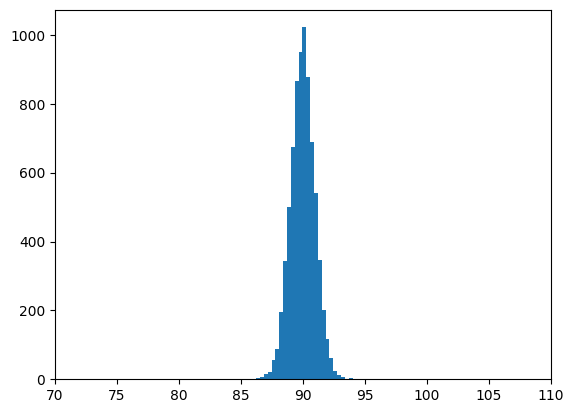

In [96]:
import numpy as np

n = 124
d = 500
d_eff = 60
X = np.random.randn(n,d)
W = np.random.randn(d,d_eff)
Y = X @ W /np.sqrt(d)
dot = Y @ Y.T/d # 
# get the elements just of the lower triangle, excluding the diagonal
elements = np.arccos(dot[np.tril_indices(n, k=-1)] ) * 180/np.pi
print(elements.shape)
plt.hist(elements, bins=30)
plt.xlim(70,110)
plt.show()